# Warming up

## Value of an European Call Option

The [Black-Scholes-Merton](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) model is a 
mathematical model applicable in financial markets containing derivative investment instruments for 
the theoretical estimation of European-style options' price. According to such model, 
__the index level at maturity__ of a call option can be modeled as it follows with z normally distributed

$$S_T(z)=S_0e^{(r-0.5\sigma^2)T+\sigma\sqrt{T}z}$$

where 
* $S_0$ is the initial stock index level
* K is the strike price of the European call option
* T is the Time-to-maturity in year 
* r is the riskless short rate 
* $\sigma^2$ is the volatility

Let's assume the following values 
* $S_0 = 105$
* K = 109 
* T = 1 
* r = 6% 
* $\sigma^2$ = 22%

In order to calculate the present value of the call option, it is possible to apply a Monte Carlo approach
according to the following procedure: 
* Let's consider R realizations of the random variable z from a standard normal distribution 
* Compute related index levels at maturity $S_T(i)$ for $z(i)\in\{1,2,...,R\}$ 
* Compute the call option value $h_T(i)=\max{(S_T(i)–K,0)}$. 
* Compute the __present value__ of the call option, i.e. 

$$C_0=e^{-rT}{R}^{-1}\sum_{i=1}^{R} h_T{(i)}$$



In [2]:
import numpy as np

def bsm(S0,r,sigma,T,K,R = 100000 , seed=500):
    np.random.seed(seed)
    z = np.random.standard_normal(R) 
    ST = S0 * np.exp(( r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)
    hT = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.sum(hT) / R
    return C0

In [3]:
import time
tm = time.time()
C0 = bsm(S0=105,r=0.06,sigma=0.22,T=1.0,K=109,R = 100000 , seed=500)
pm = time.time() - tm
print("Value of European Call Option: {0:.4g}".format(C0)+" - time[{0:.4g} secs]".format(pm))

Value of European Call Option: 10.31 - time[0.01564 secs]


Let's see how much time is necessary for 70,000,000 iterations intead of 100,000 iterations. 

In [4]:
tm = time.time()
C0 = bsm(S0=105,r=0.06,sigma=0.22,T=1.0,K=109,R = 70000000 , seed=500)
pm = time.time() - tm
print("Value of European Call Option: {0:.4g}".format(C0)+" - time[{0:.4g} secs]".format(pm))

Value of European Call Option: 10.32 - time[6.039 secs]


Let's see how we can speed up the computation with the __numexpr__ package. 

In [5]:
import numexpr as ne
def bsm_ne(S0,r,sigma,T,K,R = 70000000 , seed=500):
    np.random.seed(seed)
    z = np.random.standard_normal(R) 
    ST = ne.evaluate('S0 * exp(( r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * z)')
    hT = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.sum(hT) / R
    return C0

In [6]:
tm = time.time()
C0 = bsm_ne(S0=105,r=0.06,sigma=0.22,T=1.0,K=109,R = 70000000 , seed=500)
pm = time.time() - tm
print("Value of the European Call Option: {0:.4g}".format(C0)+" - time[{0:.4g} secs]".format(pm))

Value of the European Call Option: 10.32 - time[4.821 secs]


## Key Factors for Evaluating the Performance of a Portfolio

The __daily return__ of a stock is easily computable as it follows  $$dr(t)=\frac{P(t)}{P(t-1)}-1$$
Similarly, the __cumulative return__ of a stock  is easily computable as it follows $$cr(t)=\frac{P(t)}{P(0)}-1$$
What is it P(t)? There are basically 2 options for this value, i.e. 
* the __adjusted close price__ of a stock typically indicated in financial feed as __Adj Close__, or 
* the __close price__ of a stock typically indicated in financial feed as __Adj__. 

We take the __adjusted close price__ 
(see [What Hedge Funds Really Do](https://www.amazon.com/What-Hedge-Funds-Really-Introduction-ebook/dp/B00MYFT0TQ#nav-subnav)
to understand why).     
 
Typically for evaluating the performance of a portfolio key factors to focus on are 
1. __Cumulative return__ 
2. __Average daily return__ 
3. __Rsk__ (Standard deviation of daily return)
4. __Sharpe ratio__ 
 
We will see how to compute and plot these factors. 
   
 
### Get financial data 
Functions from __pandas.io.data__ and __pandas.io.ga__ extract data from various Internet sources into a __DataFrame__
The following sources are supported:

* Yahoo! Finance
* Google Finance
* St.Louis FED (FRED)
* Kenneth French’s data library
* World Bank
* Google Analytics

For further info see [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/remote_data.html)

In [9]:
import numpy as np
import pandas as pd
import pandas.io.data as web

df_final = web.DataReader(['GOOG','SPY'], data_source='yahoo',
                      start='1/21/2010', end='4/15/2016')

print(df_final)
print(df_final.shape)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 1570 (major_axis) x 2 (minor_axis)
Items axis: Open to Adj Close
Major_axis axis: 2010-01-21 00:00:00 to 2016-04-15 00:00:00
Minor_axis axis: GOOG to SPY
(6, 1570, 2)


In [10]:
df_final.ix[:,:,'SPY'].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-21,113.919998,114.269997,111.559998,111.699997,344859600.0,97.864196
2010-01-22,111.199997,111.739998,109.089996,109.209999,345942400.0,95.682624
2010-01-25,110.209999,110.410004,109.410004,109.769997,186937500.0,96.173257
2010-01-26,109.339996,110.470001,109.040001,109.309998,211168800.0,95.770236
2010-01-27,109.169998,110.080002,108.330002,109.830002,271863600.0,96.225829


In [11]:
print(type(df_final.ix[:,:,'SPY']))
print("\n>>> null values:"+str(pd.isnull(df_final.ix[:,:,'GOOG']).sum().sum()))

<class 'pandas.core.frame.DataFrame'>

>>> null values:0


In [12]:
df_final = web.DataReader(['GOOG','SPY'], data_source='yahoo',
                      start='1/21/1999', end='4/15/2016')
df_final.ix[:,:,'GOOG'].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1999-01-21,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-22,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-25,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-26,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-27,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(type(df_final.ix[:,:,'GOOG']))
print("\n>>> null values:"+str(pd.isnull(df_final.ix[:,:,'GOOG']).sum().sum()))

<class 'pandas.core.frame.DataFrame'>

>>> null values:8412


There is a couple of observations to be done:
1. calling __pandas.io.data__ with multiple stocks gets a __pandas.core.panel.Panel__ instead of a __pandas.DataFrame__
but filtering to specific axis (e.g. Google) we get __pandas.core.frame.DataFrame__
2. __pandas.io.data__ does not handle missing values 

Hence, we can define the following functions.

In [14]:
import matplotlib.pyplot as plt
def get_data(symbols, 
             add_ref=True,
             data_source='yahoo',
             price='Adj Close',
             start='1/21/2010', 
             end='4/15/2016'):
    """Read stock data (adjusted close) for given symbols from."""
    
    if add_ref and 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    df = web.DataReader(symbols, 
                        data_source=data_source,
                        start=start, 
                        end=end)
    
    return df[price,:,:]


get_data(symbols=['GOOG','SPY']).tail()

,GOOG,SPY
Date,,
2016-04-11,736.099976,202.964506
2016-04-12,743.090027,204.854670
2016-04-13,751.719971,206.923911
2016-04-14,753.200012,206.933854
2016-04-15,759.000000,206.705048


Also, notice that __it is not necessary to perform an initial join__ with the data range of interest filtering out 
non trading days, as __padas does it for us__ , i.e.

In [15]:
df_stock = get_data(symbols=['GOOG','SPY'],start='1/21/1999',end='4/15/2016')
print(">> Trading days from pandas:"+str(df_stock.shape[0]))
dates = pd.date_range('1/21/1999', '4/15/2016')
df = pd.DataFrame(index=dates)
print(">> Calendar days:"+str(df.shape[0]))
df = df.join(df_stock)
print(">> After join:"+str(df.shape[0]))
df = df.dropna(subset=["SPY"])
print(">> After removing non trading days:"+str(df.shape[0]))

>> Trading days from pandas:4337
>> Calendar days:6295
>> After join:6295
>> After removing non trading days:4337


### Plotting stock prices

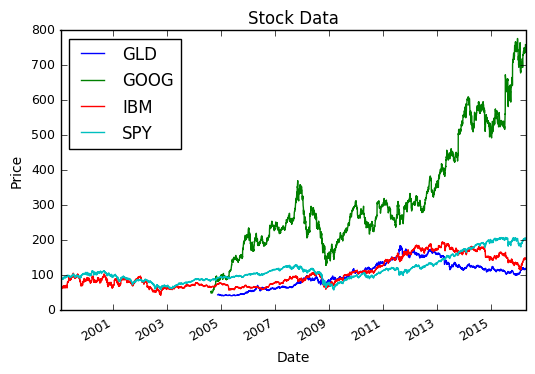

In [16]:
ax = get_data(symbols=['GOOG','SPY','IBM','GLD'],start='1/21/1999', end='4/15/2016').plot(title="Stock Data", fontsize=9)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

### Imputing missing values
As clear from above plot, we need to handle missing values. 

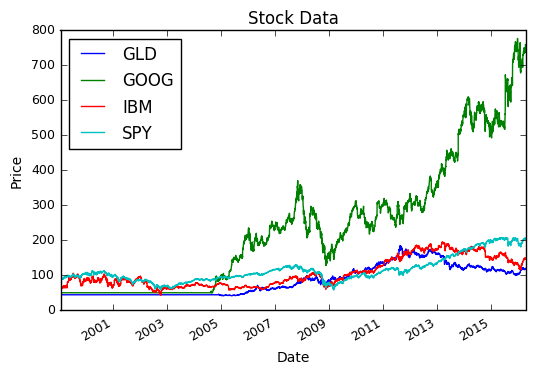

In [17]:
def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill',inplace=True)
    df_data.fillna(method='backfill',inplace=True)
    return df_data

ax = fill_missing_values(get_data(symbols=['GOOG','SPY','IBM','GLD'],
                             start='1/21/1999', 
                             end='4/15/2016')).plot(title="Stock Data", fontsize=9)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

### Normalizing prices 

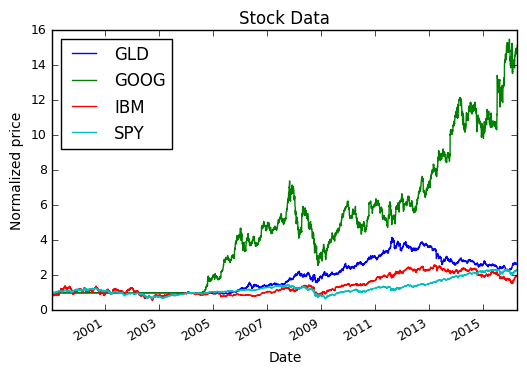

In [18]:
def normalize_data(df):
    return df/df.ix[0,:]

ax = normalize_data(
    fill_missing_values(
        get_data(
            symbols=['GOOG','SPY','IBM','GLD'],
                             start='1/21/1999', 
                             end='4/15/2016'))).plot(title="Stock Data", fontsize=9)
ax.set_xlabel("Date")
ax.set_ylabel("Normalized price")
plt.show()

### Rolling statistics
* Notice that __pandas.rolling_mean__ has been deprecated for DataFrame and will be removed in a future version.
Hence, we will replace it with __DataFrame.rolling(center=False,window=20).mean()__ 
* Notice that __pd.rolling_std__ has been deprecated for DataFrame and will be removed in a future version.
Hence, we will replace it with __DataFrame.rolling(center=False,window=20).std()__  

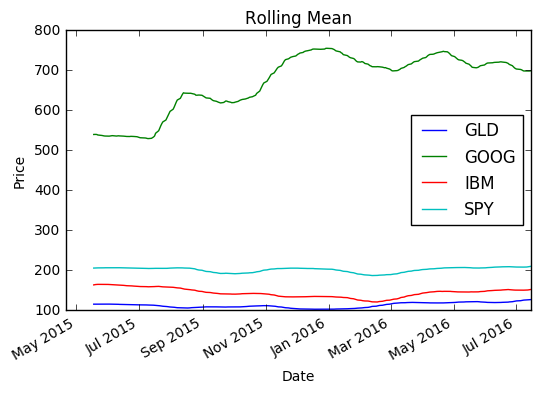

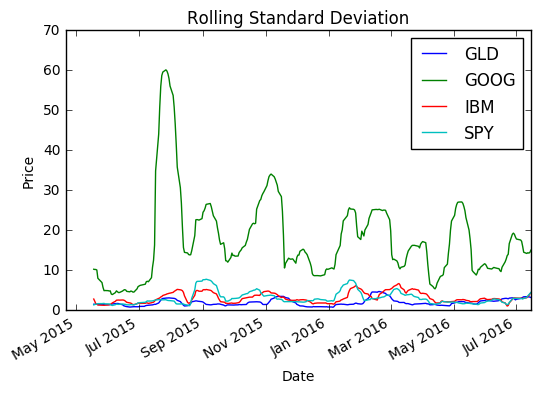

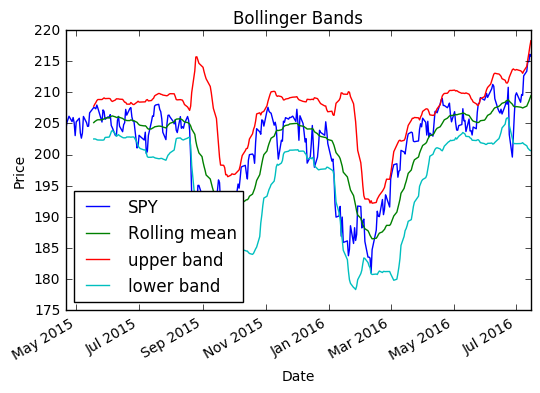

In [19]:
df = fill_missing_values(
        get_data(
            symbols=['GOOG','SPY','IBM','GLD'],
                             start='4/21/2015', 
                             end='7/15/2016'))

# 1. Computing rolling mean using a 20-day window 
rm_df = pd.DataFrame.rolling(df, window=20).mean()

ax = rm_df.plot(title="Rolling Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

# 2. Computing rolling standard deviation using a 20-day window 
rstd_df = pd.DataFrame.rolling(df, window=20).std()

ax = rstd_df.plot(title="Rolling Standard Deviation")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()


# 3. Compute upper and lower bands
def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band, lower_band = rm + 2 * rstd, rm - 2 * rstd
    return upper_band, lower_band

upper_band, lower_band = get_bollinger_bands(rm_df, rstd_df)

# Plot raw SPY values, rolling mean and Bollinger Bands
ax = df['SPY'].plot(title="Bollinger Bands",label='SPY')
rm_df['SPY'].plot(label='Rolling mean', ax=ax)
upper_band['SPY'].plot(label='upper band', ax=ax)
lower_band['SPY'].plot(label='lower band', ax=ax)

# Add axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='lower left')
plt.show()

### Daily returns
There are two ways to compute the daily return of a stock with pandas. We check they produce same 
results and plot them. 

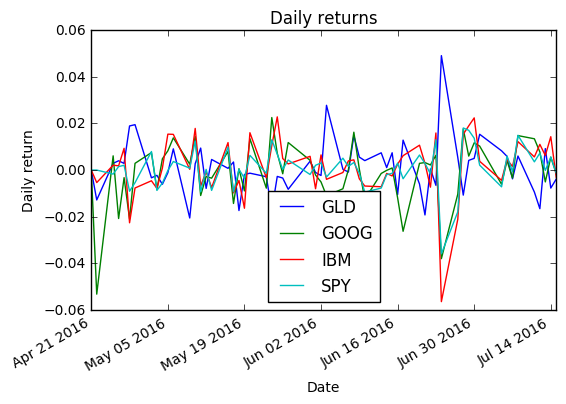

In [20]:
def compute_daily_returns_2(df):
    """Compute and return the daily return values."""
    # Note: Returned DataFrame must have the same number of rows
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.ix[0,:] = 0 
    return daily_returns

def compute_daily_returns(df):
    """Compute and return the daily return values."""
    # Note: Returned DataFrame must have the same number of rows
    daily_returns = (df / df.shift(1)) - 1 
    daily_returns.ix[0,:] = 0 
    return daily_returns

pd.util.testing.assert_frame_equal(
    compute_daily_returns(
        fill_missing_values(
            get_data(
                symbols=['GOOG','SPY','IBM','GLD'],
                start='4/21/2016', 
                end='7/15/2016'))), 
    compute_daily_returns_2(
        fill_missing_values(
            get_data(
                symbols=['GOOG','SPY','IBM','GLD'],
                start='4/21/2016', 
                end='7/15/2016'))))

ax = compute_daily_returns(fill_missing_values(
        get_data(
            symbols=['GOOG','SPY','IBM','GLD'],
                             start='4/21/2016', 
                             end='7/15/2016'))).plot(title="Daily returns")

ax.set_xlabel("Date")
ax.set_ylabel("Daily return")
plt.show()

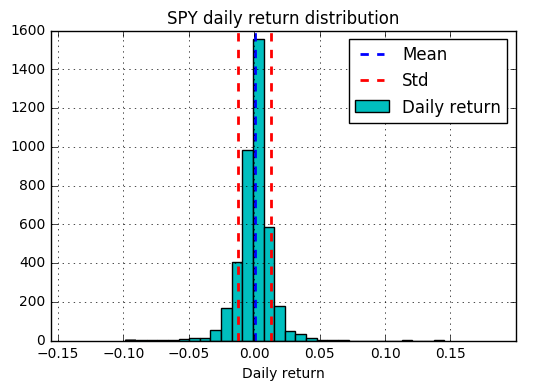

In [106]:
df = compute_daily_returns(fill_missing_values(get_data(
            symbols=['SPY'], 
            start='4/21/2000', 
            end='7/15/2016')))

plt.hist(df['SPY'],bins=30,color='c',label=['Daily return'])
plt.axvline(df['SPY'].mean(), color='b', linestyle='dashed', linewidth=2 , label='Mean')
plt.axvline(-df['SPY'].std(), color='r', linestyle='dashed', linewidth=2 , label='Std')
plt.axvline(df['SPY'].std(), color='r', linestyle='dashed', linewidth=2 )
plt.title('SPY daily return distribution')
plt.xlabel('Daily return')
plt.grid(True)
plt.legend()

plt.show()

### Cumulative returns

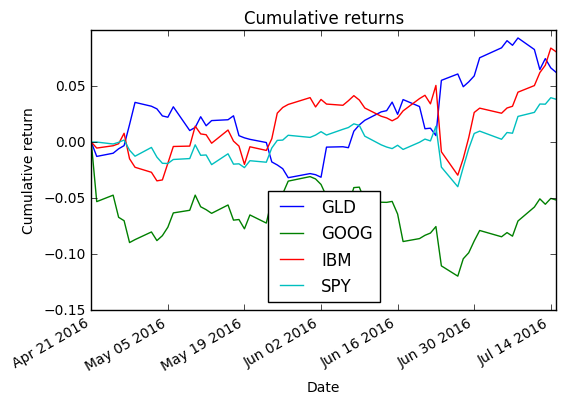

In [107]:
def cumulative_returns(df):
    return df/df.ix[0,:] - 1 

ax = cumulative_returns(fill_missing_values(
        get_data(
            symbols=['GOOG','SPY','IBM','GLD'],
                             start='4/21/2016', 
                             end='7/15/2016'))).plot(title="Cumulative returns")

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return")
plt.show()

## Sharpe Ratio
[Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) is a 
way to examine the performance of an investment by adjusting for its risk. The ratio measures the excess 
return (or risk premium) per unit of deviation in an investment asset or a trading strategy, typically 
referred to as risk (and is a deviation risk measure), named after William F. Sharpe.

The __ex-ante Sharpe ratio__ is defined as:
    $$S=\frac{E\{R_p-R_f\}}{Std\{R_p-R_f\}}$$
    
where $R_p$ is the asset return, $R_f$ is the return on a benchmark asset, 
such as the risk free rate of return. $E\{R_p-R_f\}$ is the expected value of the excess of the asset return 
over the benchmark return, and $Std\{R_p-R_f\}$ is the standard deviation of the asset return.

The __ex-post Sharpe ratio__ uses the same equation as the one above but with 
realized returns of the asset and benchmark rather than expected returns.

Examples of __risk free rates__ are 
* [LIBOR](https://en.wikipedia.org/wiki/Libor)
* Interest rate of 3 month treasury bill 
* 0% (approximation used a lot in last years)

Using __daily returns__ as $R_p$  the __ex-post Sharpe ratio__ is computable as:
    $$S=\frac{mean\{R_p^{daily}-R_f^{daily}\}}{Std\{R_p^{daily}\}}$$
    
as $R_f^{daily}$ is typically costant for several months it is possible to remove from the denominator. 
Also, $R_f^{daily}$ is typically approximable with 0% but it is possible to compute given $R_f^{yearly}$ as 
it follows remembering there are 252 trading days in a year

$$R_f^{daily}=\sqrt[252]{1+R_f^{yearly}}$$

Sharpe ratio is typically an annual measure. This means if we are using different sample frequencies 
need to apply the following formula:
    $$S^{annual}=\sqrt[2]{SPY} \times S$$
    
where $SPR$ is the number of samples per year considered in computing $S$, e.g. 

* $S^{annual}=\sqrt[2]{252} \times S^{daily}$
* $S^{annual}=\sqrt[2]{52} \times S^{weekly}$
* $S^{annual}=\sqrt[2]{12} \times S^{monthly}$

In [135]:
def sharpe_ratio(df,sample_freq='d',risk_free_rate=0.0):
    
    sr = (df - risk_free_rate).mean() / df.std()
    
    if sample_freq == 'd':
        sr = sr * np.sqrt(252)
    elif sample_freq == 'w':
        sr = sr * np.sqrt(52)
    elif sample_freq == 'm':
        sr = sr * np.sqrt(12)
    else:
        raise Exception('unkown sample frequency :'+str(sample_freq))
        
    return sr

In [143]:
# Sharpe ratio
sharpe_ratio(
    compute_daily_returns(
        fill_missing_values(
            get_data(
                symbols=['GOOG','SPY','IBM','GLD'],
                             start='4/21/2015', 
                             end='7/15/2016'))))

GLD     0.559034
GOOG    0.978098
IBM     0.174419
SPY     0.358931
dtype: float64

## Summary
For evaluating the performance of a portfolio key factors to focus on are 
1. __Cumulative return__ 
2. __Average daily return__ 
3. __Rsk__ (Standard deviation of daily return)
4. __Sharpe ratio__ 

In [162]:
df = fill_missing_values(get_data(symbols=['GOOG','SPY','IBM','GLD'],
                             start='4/21/2015', 
                             end='7/15/2016'))

In [163]:
# 1. Cumulative return
cumulative_returns(df).ix[-1,:]

GLD     0.099324
GOOG    0.348103
IBM     0.017407
SPY     0.057167
Name: 2016-07-15 00:00:00, dtype: float64

In [164]:
# 2. Average daily return
compute_daily_returns(df).mean()

GLD     0.000352
GOOG    0.001113
IBM     0.000155
SPY     0.000229
dtype: float64

In [165]:
# 3. Rsk (Standard deviation of daily return)
compute_daily_returns(df).std()

GLD     0.010003
GOOG    0.018065
IBM     0.014062
SPY     0.010117
dtype: float64

In [166]:
# 4. Sharpe ratio
sharpe_ratio(compute_daily_returns(df))

GLD     0.559034
GOOG    0.978098
IBM     0.174419
SPY     0.358931
dtype: float64